In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully 

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

**Datos**

Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.
Referencia del dataset: [LINK](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 32.2MB/s]


In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**1 - Limpieza de datos**

Alumno:

Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
Tranformar el rating 1-5 a una escala numérica de 0 a 4.

In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [7]:
df_reviews.columns

Index(['Review Text', 'Rating'], dtype='object')

Rating Distribution:
4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64


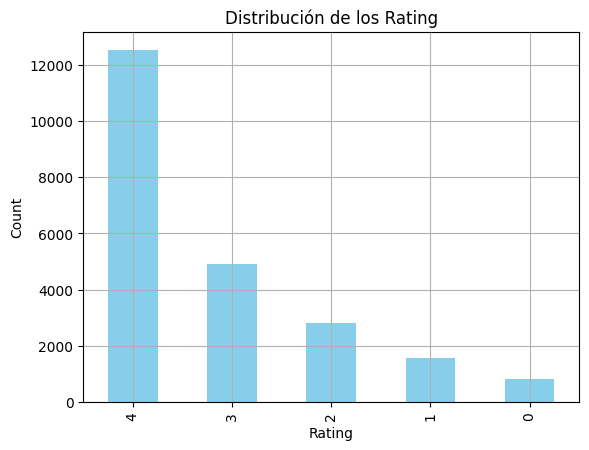

In [8]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

rating_distribution = df_reviews['Rating'].value_counts()

print("Rating Distribution:")
print(rating_distribution)

rating_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de los Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid()
plt.show()

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews_np = df_reviews['Review Text'].astype(str).values
reviews_np[:5]

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothi

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
print("Cantidad de reviews a  evaluar:", len(reviews_np))

Cantidad de reviews a  evaluar: 22641


In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews_np)
print(corpus[:200])

Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. 


In [12]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print(f"La longitud del corpus es {len(corpus)}.")

La longitud del corpus es 7011643.


In [13]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [14]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print(tokens[:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [15]:
# Alumno: ¿Cuántos tokens/palabras hay?
print(f"El numero de tokens es {len(tokens)}.")

El numero de tokens es 1372203.


In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words = num_words)
tok.fit_on_texts(tokens)
#sequences = tok.texts_to_sequences([corpus])

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
vocab_size = len(word_index)

print(f"Diccionario de palabra a índice: \n{word_index}")
print(f"Cantidad total del vocabulario: {vocab_size}")

Diccionario de palabra a índice: 
{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20, 'love': 21, 'size': 22, 'very': 23, 'have': 24, 'top': 25, 'fit': 26, 'are': 27, 'like': 28, 'be': 29, 'as': 30, 'me': 31, 'wear': 32, "it's": 33, 'great': 34, 'too': 35, "i'm": 36, 'or': 37, 'am': 38, 'just': 39, 'you': 40, 'would': 41, 'they': 42, 'up': 43, 'at': 44, 'fabric': 45, 'small': 46, 'color': 47, 'look': 48, 'if': 49, 'more': 50, 'really': 51, 'ordered': 52, 'little': 53, 'perfect': 54, 'will': 55, 'one': 56, 'these': 57, 'flattering': 58, 'well': 59, 'an': 60, 'soft': 61, 'out': 62, 'back': 63, 'because': 64, 'had': 65, 'can': 66, '\r': 67, 'comfortable': 68, 'cute': 69, 'nice': 70, 'than': 71, 'bought': 72, 'beautiful': 73, 'when': 74, 'all': 75, 'looks': 76, 'bit': 77, 'fits': 78, 'large': 79, 'shirt': 80, 'down': 81, 'which': 82, 'mate

In [18]:
# Alumno: Convertir las palabras/tokens a números
index_word = tok.index_word

print(f"Diccionario de numero a paralabra: \n{index_word}")

Diccionario de numero a paralabra: 
{1: 'the', 2: 'i', 3: 'and', 4: 'a', 5: 'it', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'on', 12: 'for', 13: 'of', 14: 'with', 15: 'was', 16: 'so', 17: 'my', 18: 'dress', 19: 'not', 20: 'that', 21: 'love', 22: 'size', 23: 'very', 24: 'have', 25: 'top', 26: 'fit', 27: 'are', 28: 'like', 29: 'be', 30: 'as', 31: 'me', 32: 'wear', 33: "it's", 34: 'great', 35: 'too', 36: "i'm", 37: 'or', 38: 'am', 39: 'just', 40: 'you', 41: 'would', 42: 'they', 43: 'up', 44: 'at', 45: 'fabric', 46: 'small', 47: 'color', 48: 'look', 49: 'if', 50: 'more', 51: 'really', 52: 'ordered', 53: 'little', 54: 'perfect', 55: 'will', 56: 'one', 57: 'these', 58: 'flattering', 59: 'well', 60: 'an', 61: 'soft', 62: 'out', 63: 'back', 64: 'because', 65: 'had', 66: 'can', 67: '\r', 68: 'comfortable', 69: 'cute', 70: 'nice', 71: 'than', 72: 'bought', 73: 'beautiful', 74: 'when', 75: 'all', 76: 'looks', 77: 'bit', 78: 'fits', 79: 'large', 80: 'shirt', 81: 'down', 82: 'which', 83:

In [19]:
# Alumno: Determinar cual es la oración más larga

sentences = corpus.split('.')
sentence_lengths = [len(sentence.split()) for sentence in sentences]
index_longest_sentence = sentence_lengths.index(max(sentence_lengths))
longest_sentence = sentences[index_longest_sentence]
print(f"La oración más larga es: '{longest_sentence.strip()}'")
print(f"Tiene {len(longest_sentence.split())} palabras.")

La oración más larga es: 'I tried on the skirt today in the store and immediately fell in love with how fluid the fabric is and how it looks and feels on, but i had something really awful happen, the zipper was hard to zip up so i just left it partially zipped but close to the top but then when i try to take it off the zipper broke and split down the middle but it was stuck on me! it was the strangest thing that i've ever had happened, and really embarrassing because i had to come out of the fitting room like that to get Read the reviews and thought i would just remove the label asap to prevent snags since i loved the item! 
however, the item came with unrepairable holes, not just snags and they are either on the neck or front sleeve which forces me to return the item asap'
Tiene 151 palabras.


(array([6.8430e+03, 3.6610e+03, 3.6210e+03, 8.6540e+03, 4.8310e+03,
        1.0002e+04, 5.0950e+03, 1.0006e+04, 4.6940e+03, 8.3310e+03,
        3.6190e+03, 6.4540e+03, 2.7330e+03, 4.4800e+03, 1.9620e+03,
        3.1670e+03, 1.3860e+03, 2.2860e+03, 8.8200e+02, 1.4780e+03,
        6.0800e+02, 9.7400e+02, 4.5100e+02, 7.0200e+02, 2.7100e+02,
        4.9300e+02, 1.8000e+02, 3.6800e+02, 1.6900e+02, 2.6700e+02,
        9.8000e+01, 1.9000e+02, 8.4000e+01, 1.4200e+02, 6.5000e+01,
        1.1100e+02, 4.1000e+01, 7.4000e+01, 4.4000e+01, 7.0000e+01,
        1.3000e+01, 4.9000e+01, 2.0000e+01, 3.5000e+01, 1.5000e+01,
        1.9000e+01, 1.3000e+01, 1.1000e+01, 1.0000e+01, 1.8000e+01,
        1.7000e+01, 4.0000e+00, 1.1000e+01, 6.0000e+00, 9.0000e+00,
        2.0000e+00, 9.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.00

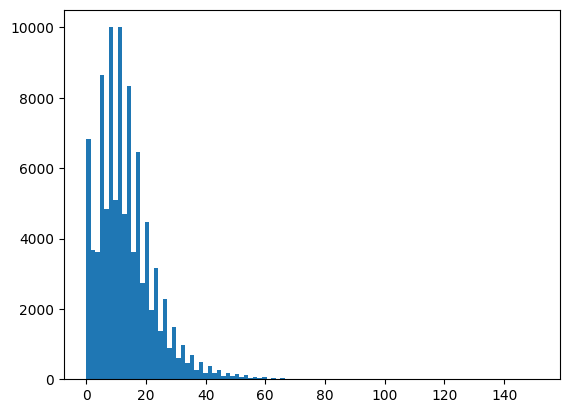

In [20]:
plt.figure()
plt.hist(sentence_lengths,bins=100)

In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia

sequences = tok.texts_to_sequences(reviews_np)
maxlen = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

print("Secuencias antes del padding:")
print(sequences[0])
print("\nSecuencias después del padding:")
print(X[0])

Secuencias antes del padding:
[253, 532, 917, 3, 662, 3, 68]

Secuencias después del padding:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 253 532 917   3 662   3  68]


In [22]:
(np.array([len(seq) for seq in sequences])<maxlen).mean()

0.999955832339561

In [23]:
# Alumno: Observar las dimensiones de la variable input

input_dimensions = X.shape
print(f"Dimensiones de la variable de entrada: {input_dimensions}")

Dimensiones de la variable de entrada: (22641, 115)


In [24]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

num_classes = 5
ratings = df_reviews['Rating']

y = to_categorical(ratings, num_classes=num_classes)

print(f"Variable 'y' en formato one-hot encoding:\n{y[:5]}")

# Imprimir las dimensiones de 'y'
print(f"Dimensiones de 'y': {y.shape}")


Variable 'y' en formato one-hot encoding:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
Dimensiones de 'y': (22641, 5)


In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir las dimensiones de los conjuntos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (18112, 115)
Dimensiones de X_test: (4529, 115)
Dimensiones de y_train: (18112, 5)
Dimensiones de y_test: (4529, 5)


In [26]:
# Alumno: determinar la dimensiones de entrada y salida
print("Dimension input:", X.shape[1])
print("Dimension output:", y.shape[1])

Dimension input: 115
Dimension output: 5


**2 - Entrenar el modelo con Embeddings + LSTM**

In [27]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [28]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=num_words+1, output_dim = 5, input_length = input_dimensions[1]))
model.add(LSTM(units = 64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units= 5 , activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 5)            10005     
                                                                 
 lstm (LSTM)                 (None, 115, 64)           17920     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

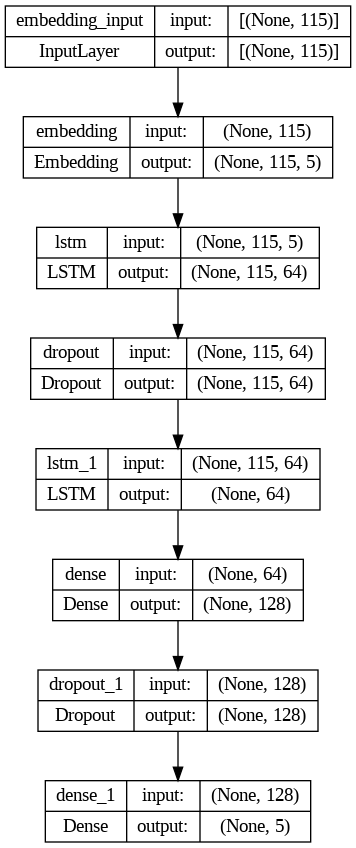

In [29]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
453/453 [==============================] - 55s 113ms/step - loss: 0.4113 - accuracy: 0.5514 - val_loss: 0.4029 - val_accuracy: 0.5468
Epoch 2/10
453/453 [==============================] - 48s 107ms/step - loss: 0.3367 - accuracy: 0.5878 - val_loss: 0.3163 - val_accuracy: 0.6105
Epoch 3/10
453/453 [==============================] - 49s 108ms/step - loss: 0.3020 - accuracy: 0.6288 - val_loss: 0.3227 - val_accuracy: 0.6100
Epoch 4/10
453/453 [==============================] - 51s 112ms/step - loss: 0.2944 - accuracy: 0.6374 - val_loss: 0.3119 - val_accuracy: 0.6083
Epoch 5/10
453/453 [==============================] - 53s 117ms/step - loss: 0.2892 - accuracy: 0.6419 - val_loss: 0.3156 - val_accuracy: 0.6119
Epoch 6/10
453/453 [==============================] - 55s 122ms/step - loss: 0.2853 - accuracy: 0.6501 - val_loss: 0.3155 - val_accuracy: 0.6150
Epoch 7/10
453/453 [==============================] - 54s 120ms/step - loss: 0.2825 - accuracy: 0.6544 - val_loss: 0.3169 - val_ac

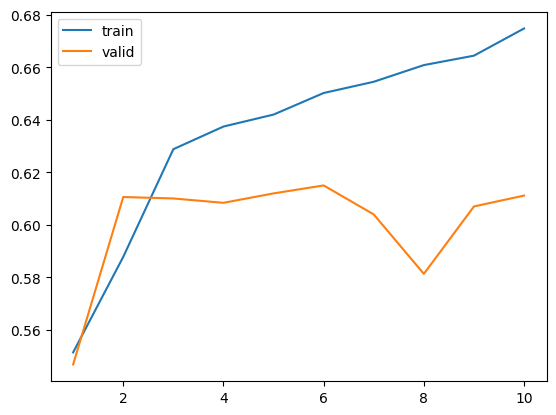

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [32]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 6s 40ms/step - loss: 0.3128 - accuracy: 0.6333


[0.31281113624572754, 0.6332523822784424]

In [33]:
y_hat_prob = model.predict(X_test)

142/142 [==============================] - 5s 29ms/step


In [34]:
max_indices = np.argmax(y_hat_prob, axis=1)
y_hat_prob = np.zeros_like(y_hat_prob)
y_hat_prob[np.arange(y_hat_prob.shape[0]), max_indices] = 1

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_hat_prob, average='weighted')
recall = recall_score(y_test, y_hat_prob, average='weighted')
f1 = f1_score(y_test, y_hat_prob, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print("Presision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Presision: 0.5958173650121393
Recall: 0.6332523735924045
F1 score: 0.6037002956212697


**Ahora lo mismo pero tratando de balancear mas el dataset**

Primero lo que se va a hacer es unir los puntajes:

- 0, 1 y 2 como puntaje bajo;

- 3 como puntaje aceptable;

- 4 como puntaje alto.

In [37]:
condiciones = [(df_reviews['Rating'] < 3), (df_reviews['Rating'] == 3), (df_reviews['Rating'] == 4)]

valores = ['Bajo', 'Aceptable', 'Alto']

# Aplicar las condiciones y asignar los valores a una nueva columna

df_reviews['Rating_modified'] = np.select(condiciones, valores)


Rating Distribution:
Alto         12540
Bajo          5193
Aceptable     4908
Name: Rating_modified, dtype: int64


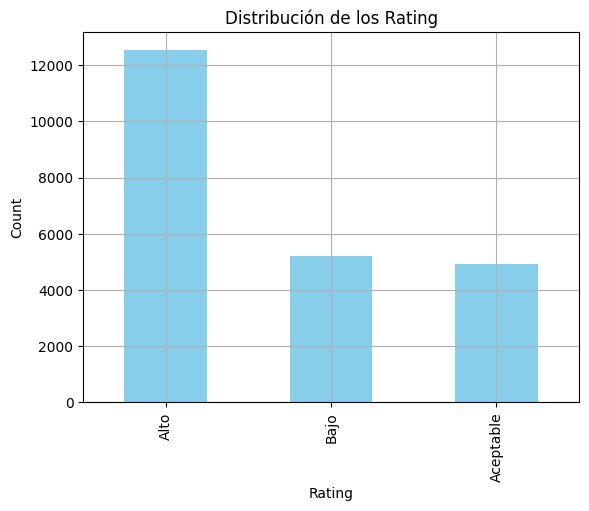

In [38]:
rating_distribution = df_reviews['Rating_modified'].value_counts()

print("Rating Distribution:")
print(rating_distribution)

rating_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de los Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid()
plt.show()

Aunque ahora mejoro la distribucion luego se aplicara un Undersampling

In [39]:
rating_modified = df_reviews['Rating_modified']

y = pd.get_dummies(rating_modified, columns=['Rating_modified'], prefix='Rating_modified')

In [40]:
 y = y.values
 y.shape

(22641, 3)

In [41]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [42]:
y_train.shape

(18112, 3)

In [43]:
model1 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model1.add(Embedding(input_dim=num_words+1, output_dim = 3, input_length = input_dimensions[1]))
model1.add(LSTM(units = 64, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model1.add(Dense(units=128, activation='relu'))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units= 3 , activation='sigmoid'))

model1.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 3)            6003      
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           17408     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [44]:
hist1 = model1.fit(X_resampled, y_resampled, epochs=10, validation_split=0.2)

Epoch 1/10
298/298 [==============================] - 42s 127ms/step - loss: 0.5760 - accuracy: 0.4761 - val_loss: 0.5604 - val_accuracy: 0.5521
Epoch 2/10
298/298 [==============================] - 39s 130ms/step - loss: 0.4922 - accuracy: 0.6003 - val_loss: 0.8386 - val_accuracy: 0.2355
Epoch 3/10
298/298 [==============================] - 34s 115ms/step - loss: 0.4682 - accuracy: 0.6381 - val_loss: 0.6600 - val_accuracy: 0.3858
Epoch 4/10
298/298 [==============================] - 37s 124ms/step - loss: 0.4558 - accuracy: 0.6561 - val_loss: 0.5149 - val_accuracy: 0.6725
Epoch 5/10
298/298 [==============================] - 36s 120ms/step - loss: 0.4451 - accuracy: 0.6691 - val_loss: 0.7462 - val_accuracy: 0.4060
Epoch 6/10
298/298 [==============================] - 37s 124ms/step - loss: 0.4356 - accuracy: 0.6821 - val_loss: 0.6301 - val_accuracy: 0.4920
Epoch 7/10
298/298 [==============================] - 38s 129ms/step - loss: 0.4312 - accuracy: 0.6898 - val_loss: 0.7466 - val_ac

In [46]:
y_hat_prob = model1.predict(X_test)
max_indices = np.argmax(y_hat_prob, axis=1)
y_hat_prob = np.zeros_like(y_hat_prob)
y_hat_prob[np.arange(y_hat_prob.shape[0]), max_indices] = 1

142/142 [==============================] - 5s 28ms/step


In [47]:
precision = precision_score(y_test, y_hat_prob, average='weighted')
recall = recall_score(y_test, y_hat_prob, average='weighted')
f1 = f1_score(y_test, y_hat_prob, average='weighted')
print("Presision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Presision: 0.7243416619010168
Recall: 0.6129388385957165
F1 score: 0.6409293768942883
